# Fast simulation of lensed quasar imaging data

__authors__: @aymgal, @austinpeel

__last update__: 06/02/24

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none', origin='lower')

# Basic imports
import os
import numpy as np
from copy import deepcopy
import time
from functools import partial
from pprint import pprint
from astropy.io import fits

# JAX-related
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# Probabilistic language
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.distributions import constraints

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.PointSourceModel.point_source_model import PointSourceModel
from herculens.LensImage.lens_image import LensImage
from herculens.Inference.loss import Loss
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.jaxopt import JaxoptOptimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

from herculens.Inference.Optimization.optax import OptaxOptimizer

/Users/aymgal/miniconda3/envs/herculens39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## General setup and model components choices

### Coordinates grid

In [2]:
npix = 160  # number of pixel on a side
pix_scl = 0.03  # pixel size in arcsec
half_size = npix * pix_scl / 2.
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2.  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (160, 160) pixels
pixel size : 0.03 arcsec
x range    : (-2.385, 2.385) arcsec
y range    : (-2.385, 2.385) arcsec


### Point spread function (PSF)

In [3]:
psf_supersampling = 1
psf_kernel_file = f"psf_kernel_NIRCam_F444W_STARRED_super{psf_supersampling}.fits"
psf_kernel = fits.getdata(os.path.join("data", psf_kernel_file), header=False)
psf_kernel = psf_kernel.astype(np.float64)

psf = PSF(
    psf_type='PIXEL',
    kernel_point_source=psf_kernel,
    kernel_supersampling_factor=psf_supersampling,
)

### Noise

In [4]:
# exposure time, used for estimating the shot noise
exp_time = 2000.  # seconds
# standard deviation of the background noise
sigma_bkg = 0.005  # electrons/second

noise = Noise(
    npix, npix,
    background_rms=sigma_bkg,
    exposure_time=exp_time,
)

### Lens galaxy

We assume a SIE embedded in an external shear

In [5]:
# Lens mass
lens_mass_model_input = MassModel(['EPL', 'SHEAR'])

# Einstein radius
theta_E = 1.4
# powerlaw slope
gamma = 2.1
# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
kwargs_lens_input = [
    {'theta_E': theta_E, 'gamma': gamma, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)

### Lens light

Elliptical Sérsic profile

In [6]:
# Lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
sopurce_amp = 10.
kwargs_lens_light_input = [
    {'amp': sopurce_amp, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

### Source galaxy

Elliptical Sérsic profile

In [7]:
beta_true = [0.04, 0.08]
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 8.0, 'R_sersic': 0.1, 'e1': 0.02, 'e2': -0.04, 'n_sersic': 1.5, 'center_x': beta_true[0], 'center_y': beta_true[1]}
]

### Point source model (quasar images)

In [8]:
# Create a pixel grid for solving the lens equation
ps_grid_npix = 2 * npix + 1
ps_grid_pix_scl = (pix_scl * npix) / ps_grid_npix
ps_grid_half_size = ps_grid_npix * ps_grid_pix_scl / 2.
ps_grid_ra_at_xy_0 = ps_grid_dec_at_xy_0 = -ps_grid_half_size + ps_grid_pix_scl / 2.
ps_grid_transform_pix2angle = ps_grid_pix_scl * np.eye(2)
kwargs_ps_grid = {'nx': ps_grid_npix, 'ny': ps_grid_npix,
                  'ra_at_xy_0': ps_grid_ra_at_xy_0, 'dec_at_xy_0': ps_grid_dec_at_xy_0,
                  'transform_pix2angle': ps_grid_transform_pix2angle}
ps_grid = PixelGrid(**kwargs_ps_grid)

point_source_type_list = ['SOURCE_POSITION']
point_source_model_input = PointSourceModel(point_source_type_list, lens_mass_model_input, ps_grid)

ps_amp = 8.
kwargs_ps = {'ra': beta_true[0], 'dec': beta_true[1], 'amp': ps_amp}
kwargs_point_source_input = [kwargs_ps]


### Setup the lens equation solver

It relies on hyperparameters, whose default values should work for most applications.

__WARNING__: JAX needs to know how many image should be predicted, in order to know in advance the size of the output buffer array. Hence, it will _always_ predict this number of images, for any lens model. Keep this in mind!

In [9]:

# Solver hyperparameters
niter_solver = 5
triangle_scale_factor = 2
n_triangle_subdivisions = 3
kwargs_lens_equation_solver = {'nsolutions': 5, 
                               'niter': niter_solver, 
                               'scale_factor': triangle_scale_factor, 
                               'nsubdivisions': n_triangle_subdivisions}

# Point source position accuracy
ps_accuracy = ps_grid_pix_scl * (triangle_scale_factor / 4**n_triangle_subdivisions)**(niter_solver / 2.)
print(f"PS max error : {ps_accuracy:.4}")

PS max error : 2.581e-06


### Plotting engine

In this notebook we use it only for practical reasons (colormap and scalings).

In [10]:
plotter = Plotter(flux_vmin=1e-3, flux_vmax=1e0, res_vmax=4)

### Generate the lens image

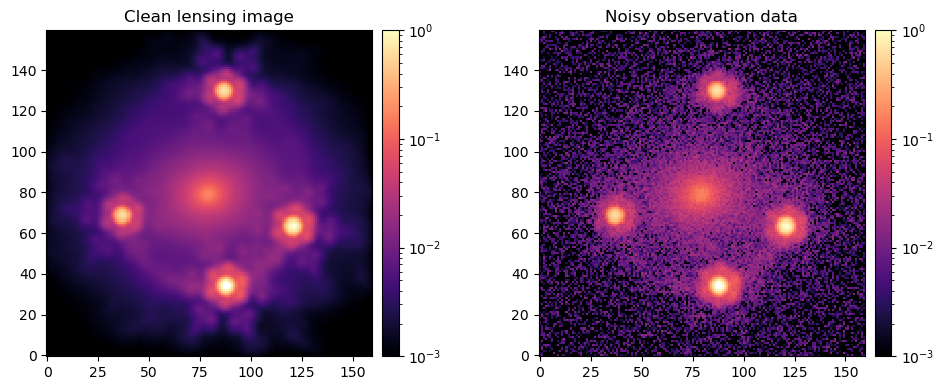

In [11]:
# Supersampling resolution for ray-tracing and light profile evaluations
model_supersampling = 3

# Generate a lensed image based on source and lens models
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_mass_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         point_source_model_class=point_source_model_input,
                         kwargs_numerics=dict(supersampling_factor=model_supersampling),
                         kwargs_lens_equation_solver=kwargs_lens_equation_solver)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input,
                        kwargs_point_source=kwargs_point_source_input,
                        point_source_add=True,
                        source_add=True)

image = lens_image.model(**kwargs_all_input)

data = lens_image.simulation(
    **kwargs_all_input, 
    compute_true_noise_map=True, 
    prng_key=jax.random.PRNGKey(42),
)

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

## Batch generation of images

### Define the prior distribution

NOTE: Here we use a `numpyro` probabilistic model to define the probability distribution of each parameter. This allows to very simply draw a sample from the prior, even it contains conditional relationships between variables. However, using `numpyro` is totally optional here, and just drawing random values by any another way would work fine as well.

In [12]:
def prior_model():
    """This function defines the probabilities of all simulation parameters
    and allows to sampler consistently from those, taking into account conditional probabilities
    """
    # Parameters of the quasar
    amp_quasar = numpyro.sample('quasar_amp', dist.LogNormal(3.0, 0.1))
    cx_quasar = numpyro.sample('quasar_center_x', dist.Normal(0., 0.05))
    cy_quasar = numpyro.sample('quasar_center_y', dist.Normal(0., 0.05))

    # Parameters of the source
    amp_host = numpyro.sample('source_amp', dist.LogNormal(2.0, 0.1))
    R_sersic_host = numpyro.sample('source_R_sersic', dist.TruncatedNormal(0.2, 0.1, low=0.05, high=2.))
    n_sersic_host = numpyro.sample('source_n', dist.Uniform(0.5, 6.))
    e1_host = numpyro.sample('source_e1', dist.TruncatedNormal(0.05, 0.05, low=-0.3, high=0.3))
    e2_host = numpyro.sample('source_e2', dist.TruncatedNormal(0.05, 0.05, low=-0.3, high=0.3))
    cx_host = cx_quasar
    cy_host = cy_quasar

    # Center of the lens light
    cx_light = numpyro.sample('light_center_x', dist.Normal(0., pix_scl/2.))
    cy_light = numpyro.sample('light_center_y', dist.Normal(0., pix_scl/2.))

    # Parameters of the lens light
    amp_light = numpyro.sample('light_amp', dist.LogNormal(2.0, 0.1))
    R_sersic_light = numpyro.sample('light_R_sersic', dist.Normal(1.0, 0.1)) 
    n_sersic_light = numpyro.sample('light_n', dist.Uniform(2., 5.))
    e1_light = numpyro.sample('light_e1', dist.TruncatedNormal(0.1, 0.05, low=-0.3, high=0.3))
    e2_light = numpyro.sample('light_e2', dist.TruncatedNormal(0.04, 0.05, low=-0.3, high=0.3))

    # power-law, with center relative the lens light
    theta_E_lens = numpyro.sample('lens_theta_E', dist.TruncatedNormal(1., 0.2, low=0.4, high=1.6))
    gamma_lens = numpyro.sample('lens_gamma', dist.TruncatedNormal(2., 0.1, low=1.5, high=2.5))
    e1_lens = numpyro.sample('lens_e1', dist.TruncatedNormal(0.1, 0.05, low=-0.3, high=0.3))
    e2_lens = numpyro.sample('lens_e2', dist.TruncatedNormal(0.04, 0.05, low=-0.3, high=0.3))
    center_x_lens = numpyro.sample('lens_center_x', dist.Normal(cx_light, 0.005))
    center_y_lens = numpyro.sample('lens_center_y', dist.Normal(cy_light, 0.005))
    # external shear
    gamma1_lens = numpyro.sample('lens_gamma1', dist.TruncatedNormal(-0.01, 0.05, low=-0.3, high=0.3))
    gamma2_lens = numpyro.sample('lens_gamma2', dist.TruncatedNormal(0.03, 0.05, low=-0.3, high=0.3))

def params2kwargs(params):
    """Function that takes the flattened dictionary of numpyro parameters
    and reshape it back to the argument of lens_image.model() or lens_image.simulation()
    """
    kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
    'gamma': params['lens_gamma'],
    'e1': params['lens_e1'],
    'e2': params['lens_e2'],
    'center_x': params['lens_center_x'],
    'center_y': params['lens_center_y']},
    {'gamma1': params['lens_gamma1'],
    'gamma2': params['lens_gamma2'],
    'ra_0': 0.0,
    'dec_0': 0.0}],
    'kwargs_source': [{'amp': params['source_amp'],
    'R_sersic': params['source_R_sersic'],
    'n_sersic': params['source_n'],
    'e1': params['source_e1'],
    'e2': params['source_e2'],
    'center_x': params['quasar_center_x'],
    'center_y': params['quasar_center_y']}],
    'kwargs_lens_light': [{'amp': params['light_amp'],
    'R_sersic': params['light_R_sersic'],
    'n_sersic': params['light_n'],
    'e1': params['light_e1'],
    'e2': params['light_e2'],
    'center_x': params['light_center_x'],
    'center_y': params['light_center_y']}],
    'kwargs_point_source': [{'ra': params['quasar_center_x'], 'dec': params['quasar_center_y'], 'amp': params['quasar_amp']}]}
    return kw

In [13]:
# draw random sample from prior
def draw_from_prior(key):
    seeded_model = handlers.seed(prior_model, key)
    trace = handlers.trace(seeded_model).get_trace()
    sample = {site['name']: site['value'] for site in trace.values() if not site.get('is_observed', False)}
    return sample

random_seed = 18
pnrg_key = jax.random.PRNGKey(random_seed)
# _, subkey = jax.random.split(pnrg_key)
random_sample = draw_from_prior(pnrg_key)
print(random_sample)

{'quasar_amp': Array(20.42504804, dtype=float64), 'quasar_center_x': Array(0.03347947, dtype=float64), 'quasar_center_y': Array(0.13111353, dtype=float64), 'source_amp': Array(6.52430067, dtype=float64), 'source_R_sersic': Array(0.14654959, dtype=float64), 'source_n': Array(2.52442784, dtype=float64), 'source_e1': Array(0.14023595, dtype=float64), 'source_e2': Array(-0.0046335, dtype=float64), 'light_center_x': Array(0.00316062, dtype=float64), 'light_center_y': Array(0.01514346, dtype=float64), 'light_amp': Array(8.29904035, dtype=float64), 'light_R_sersic': Array(1.02345871, dtype=float64), 'light_n': Array(4.72851756, dtype=float64), 'light_e1': Array(0.1256868, dtype=float64), 'light_e2': Array(-0.00308648, dtype=float64), 'lens_theta_E': Array(1.34797088, dtype=float64), 'lens_gamma': Array(1.91811981, dtype=float64), 'lens_e1': Array(0.17444567, dtype=float64), 'lens_e2': Array(0.09281667, dtype=float64), 'lens_center_x': Array(0.00973164, dtype=float64), 'lens_center_y': Array(0

In [14]:
# display it as kwargs
pprint(params2kwargs(random_sample))

{'kwargs_lens': [{'center_x': Array(0.00973164, dtype=float64),
                  'center_y': Array(0.01270016, dtype=float64),
                  'e1': Array(0.17444567, dtype=float64),
                  'e2': Array(0.09281667, dtype=float64),
                  'gamma': Array(1.91811981, dtype=float64),
                  'theta_E': Array(1.34797088, dtype=float64)},
                 {'dec_0': 0.0,
                  'gamma1': Array(-0.07097672, dtype=float64),
                  'gamma2': Array(0.06665979, dtype=float64),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': Array(1.02345871, dtype=float64),
                        'amp': Array(8.29904035, dtype=float64),
                        'center_x': Array(0.00316062, dtype=float64),
                        'center_y': Array(0.01514346, dtype=float64),
                        'e1': Array(0.1256868, dtype=float64),
                        'e2': Array(-0.00308648, dtype=float64),
                        'n_sersic': Ar

## Generate a big batch of images

### `jit`ted function for fast image generation

We start by writing the main function, that takes as input a random number generator key and outputs an image based on parameters values drawn from the prior distribution. It also outputs quasar image positions and amplitudes predicted by the lens equation solver and the magnification model.

In [15]:
@jax.jit
def simulate_image(key):
    new_key, *subkeys = jax.random.split(key, num=3)
    params = draw_from_prior(subkeys[0])
    kwargs = params2kwargs(params)
    image = lens_image.simulation(
        **kwargs, 
        compute_true_noise_map=True, 
        prng_key=subkeys[1],
    )
    (theta_x, theta_y, amp) = lens_image.PointSourceModel.get_multiple_images(
            kwargs['kwargs_point_source'], 
            kwargs['kwargs_lens'], 
            kwargs_lens_equation_solver, 
            k=None
    )
    return new_key, image, (theta_x, theta_y, amp)

### Measure some timings

In [16]:
%%time
_ = simulate_image(jax.random.PRNGKey(10)) # first call -> longer runtime

CPU times: user 9.22 s, sys: 2.89 s, total: 12.1 s
Wall time: 8.58 s


In [17]:
%%time
_, example_image, _ = simulate_image(jax.random.PRNGKey(10)) # second and subsequent calls -> much faster!

CPU times: user 81.6 ms, sys: 7.39 ms, total: 89 ms
Wall time: 19.9 ms


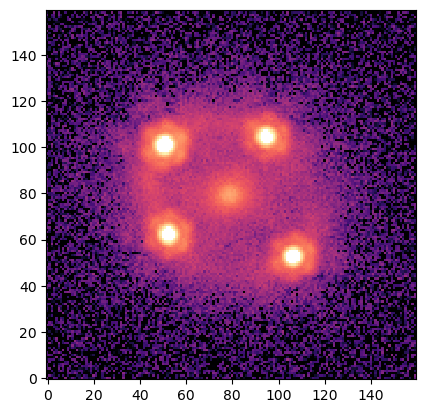

In [18]:
plt.imshow(example_image, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plt.show()

### Main simulation loop

Below we generate 1'000 images of lensed quasars.

In [19]:
%%time
start_seed = 25634
key = jax.random.PRNGKey(random_seed)
# NOTE: using numpyro key system is just to make this deterministic and is optional

num_sims = 1_000
sim_list = []
img_list = []
for i in range(num_sims):
    # simulate image
    key, sim, (pos_x, pos_y, amp) = simulate_image(key)  # this should be FAST
    # save to lists
    sim_list.append(sim)
    # unpack and convert to numpy arrays
    pos_x, pos_y = np.array(pos_x[0]), np.array(pos_y[0])
    amp = np.array(amp)
    img_list.append((pos_x, pos_y, amp))  # quasar image (x, y) positions

CPU times: user 1min 19s, sys: 4.84 s, total: 1min 24s
Wall time: 17.7 s


### Plot a subset of the simulations

0 [ 0.5655132  -0.00229689 -0.31994255 -0.31994169 -0.31994169]
2 [ 0.0059325  -0.01049117  0.6583729   0.65835569  0.65835569]
7 [ 0.23243961 -0.01950572 -0.62867247 -0.62867591 -0.62867591]
8 [-0.07559093  0.15312237  0.00929917 -0.07558749 -0.07558749]
12 [0.1560959  0.01622162 0.33153173 0.15611138 0.15611138]
13 [-0.74980945  0.6710604  -0.01281563  0.67106298  0.67106298]
17 [-0.01381314 -0.47403913  0.26063942  0.26063253  0.26063253]
26 [-0.07003362  0.01349472 -0.38737874 -0.07002415 -0.07002415]
27 [-0.26074155 -0.23913436  0.01366493  0.01366149  0.01366149]


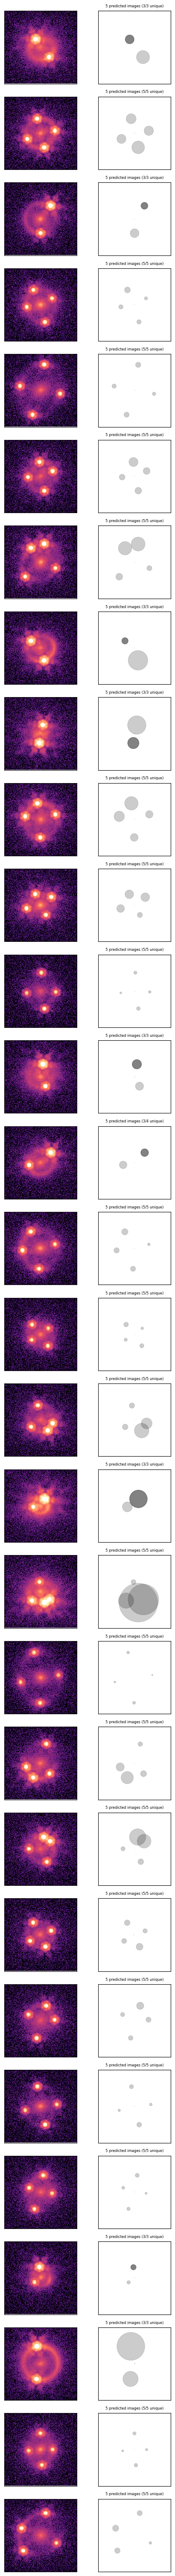

In [20]:
num_show = min(30, num_sims)
fig, axes = plt.subplots(num_show, 2, figsize=(5, 60))
for i in range(num_show):
    sim = sim_list[i]
    pos_x, pos_y, amp = img_list[i]
    num_img = pos_x.size  # that should be equal to kwargs_lens_equation_solver['nsolutions']

    # number of duplicated images
    num_x_unique = np.unique(np.round(pos_x, decimals=4)).size
    num_y_unique = np.unique(np.round(pos_y, decimals=4)).size
    # if num_x_unique < 5:
    #     print(i, pos_x)

    ax = axes[i, 0]
    extent = lens_image.Grid.plt_extent
    ax.imshow(sim, norm=plotter.norm_flux, cmap=plotter.cmap_flux, extent=extent)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[i, 1]
    ax.set_title(f"{num_img} predicted images ({num_x_unique}/{num_y_unique} unique)", fontsize=6)
    ax.scatter(pos_x, pos_y, c='black', s=0.01*amp**2, marker='o', alpha=0.2, linewidths=0.5)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
fig.tight_layout()
plt.show()

#### Important note about image multiplicity

In the above plots (right column), the marker size reflects the magnification and the opacity is larger when two or more multiple images have been predicted __at the same location__. This is because the number of predicted images must be fixed for JAX to compile the lens equation solver. Hence, care must be taken, for instance for doubly lensed quasar images, since there may be actually 3 times the same quasar image appearing in the resulting image! The central image, however, can be ignored as it is extremelly de-magnified